# Map Heuristic Approximation

The goal is to use neural networks to approximate map heuristics

Let's start simple. Treat the problem as a regression problem for each map cell and use a simple fully connected neural network to estimate the value/heuristic (label). Let's see what this network can do.

## Custom data loader

Creating the custom data loader to load our dataset. Each entry in the dataset is a tuple (A,M) where A is nxn array containing 0s for free space, 1s for obstacles and 0.5 for the goal location. There is only one goal location. The labels contain a nxn array where each cell contains the Value of each cell. The Value is a measure of "closeness" to the goal cell.

In [207]:
import os
import torch
import torch.nn as nn
import numpy as np


class MapDataLoader(torch.utils.data.Dataset):
    def __init__(self,file,root="./"):
        self.data = np.load(os.path.join(root,file))
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self,index):
        return self.data[index][0],self.data[index][1]

## Fully connected network

Let's define a simple fully connected network. We'll be experimenting with number of layers and nodes per layer. 

In [208]:
from functools import reduce
    
class Network(nn.Module):
    def __init__(self,inputs,hidden1,hidden2,hidden3,hidden4,output):
        super(Network,self).__init__()
        self.fc1   = nn.Linear(inputs,hidden1)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Linear(hidden1,hidden2)
        self.relu2 = nn.ReLU()
        self.fc3   = nn.Linear(hidden2,hidden3)
        self.relu3 = nn.ReLU()
        self.fc4   = nn.Linear(hidden3,hidden4)
        self.relu4 = nn.ReLU()
        self.fc5   = nn.Linear(hidden4,output)
        self.sig   = nn.Sigmoid()
        
    def forward(self,x):
        y = self.fc1(x)
        y = self.relu1(y)
        y = self.fc2(y)
        y = self.relu2(y)
        y = self.fc3(y) 
        y = self.relu3(y)
        y = self.fc4(y)
        y = self.relu4(y)
        y = self.fc5(y)
        y = self.sig(y)
        return y
        

## Custom loss function

Let's create a custom loss function to better guide the learning process. Since we are treating this as a regression problem, the primary component of the loss function should involve a MSE loss. Additionally, we know what the outputs values should be for the map cells that already contain obstacles. Also, we know what the value should be for the goal position. The cost is defined as follows for input $x$ and prediction $\hat{y}$ with label $y$

$L_1 = \frac{1}{N}\sum||y-\hat{y}||$

$L_2 = \frac{1}{n}\sum||\lambda_2 z y ||$

$L_3 = \frac{1}{n}\sum||\lambda_1 w - wy||$


$L = L_1+L_2+L_3$

Here $z$ is a matrix that contains 1s for obstacle cells and 0s for free space. Note that $z=x$ at all cells except at the goal cell. $w$ is a zero matrix with 1 at the goal cell.


In [269]:
from torch import tensor
mseloss = torch.nn.MSELoss()
def map_loss(inputs,outputs,labels,p1=0.0,p2=0.0):
    At = inputs.detach().clone()
    Bt = outputs.clone()
    Ct = torch.zeros(At.shape)
    Dt = torch.zeros(At.shape)
    mask1 = At > 0.6
    mask2 = torch.logical_and(At > 0.49,At < 0.51)
    Ct[mask1] = 1.0
    Dt[mask2] = 1.0
    loss1 = mseloss(outputs,labels)
    loss2 = torch.mean(torch.norm(p1*(Ct*Bt),dim=0))
    loss3 = torch.mean(torch.norm(p2*(Dt-Dt*Bt),dim=0))
    loss = loss1+loss2+loss3
    return loss

In [279]:
data_location = '5by5_Obs'
N = 5
network = Network(N**2,500,500,100,100,N**2)

In [271]:
learning_rate = 0.001
numEpochs = 10
optimizer = torch.optim.Adam(network.parameters(),lr=learning_rate)

In [272]:
train_loader = torch.utils.data.DataLoader(dataset=MapDataLoader('dataset_train.npy',data_location),batch_size=30,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=MapDataLoader('dataset_test.npy',data_location),batch_size=30,shuffle=False)
total_steps = len(train_loader)

In [ ]:
testid = '5x5_obs1'
p1 = 0.0
p2 = 0.0
for epoch in range(numEpochs):
    avg_loss = 0
    for i,(data,label) in enumerate(train_loader):
        inputs = data.reshape(-1,N**2).float()
        labels = label.reshape(-1,N**2).float()
        optimizer.zero_grad()
        outputs = network(inputs)
        loss = map_loss(inputs,outputs,labels,p1,p2)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    avg_loss /= total_steps
    print('Average loss after epoch %d:%f' % (i+1,avg_loss))
  
          
torch.save(network,os.path.join(data_location,testid+'.pt'))

In [282]:
## debugging
network = torch.load(os.path.join(data_location,testid+'.pt'))
network.eval()
from MapGenerator import PlotMap
loss = 0
with torch.no_grad():
    data,label = next(iter(test_loader))
    inputs = data.reshape(-1,N**2).float()
    labels = label.reshape(-1,N**2).float()    
    outputs = network(inputs)
    loss +=  map_loss()
    #print(label[0].numpy().reshape(N,N))
    #print(outputs[0].reshape(N,N))

[[0.70339526 0.         0.76887237 0.79077404 0.820621  ]
 [0.71050026 0.73195881 0.76250347 0.80679161 0.86704616]
 [0.         0.74505326 0.7731993  0.83944042 1.        ]
 [0.         0.         0.77704043 0.81168756 0.86951853]
 [0.         0.7620833  0.76978111 0.7935463  0.82321709]]
[[7.4086940e-01 2.6024721e-04 7.7304900e-01 8.3920503e-01 8.7558687e-01]
 [8.0143070e-01 7.3447627e-01 7.5702995e-01 8.5137439e-01 8.8413084e-01]
 [4.0363693e-03 7.1227705e-01 8.0166757e-01 8.2327884e-01 8.6186916e-01]
 [6.1122410e-02 2.9402161e-05 8.1865412e-01 8.2359087e-01 8.3274496e-01]
 [4.9846908e-03 7.8844792e-01 8.1258196e-01 8.3023727e-01 6.8445021e-01]]


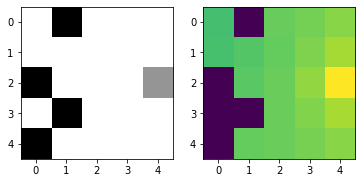

In [283]:
PlotMap(inputs[0].numpy().reshape(N,N),labels[0].numpy().reshape(N,N))

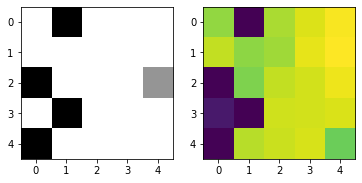

In [284]:
PlotMap(inputs[0].numpy().reshape(N,N),outputs[0].reshape(N,N))